In [58]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from math import sqrt
import random
from collections import deque
import itertools
from IPython.display import display_html, Image

import pickle
import multiprocessing
from multiprocessing import Process
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn import preprocessing

from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, HoverTool, Span, Label
from bokeh.palettes import Category10
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.5f' % x)

pd.set_option("display.max_rows", 8)
pd.set_option("display.max_columns", 25)

def frange(start, stop, step):
    i = start
    while i < stop:
        yield round(i, ndigits=2)
        i += step
        
def save_model(model, filepath):
    with open(filepath, 'wb') as file:
        pickle.dump(model, file)
        
def load_model(filepath):
    with open(filepath, 'rb') as file:
        return pickle.load(file)

# Data Preperation

In [3]:
cases_US = pd.read_csv("../data/Final Tables/US_all_vars.csv").iloc[:,1:]
cases_US['Date'] = pd.to_datetime(cases_US['Date'], cache=True)
# cases_US['Date'] = cases_US['Date'].apply(lambda x:x.toordinal())
cases_US = cases_US.drop(['FIPS', 'Country_Region', 'Total_Cases', 'State', 'County_FIPS',
                          'Phase.0', 'Phase.1', 'Phase.2', 'Phase.3', 'Abbreviation', 'Month',
                          'Lat', 'Long'],axis=1)

cases_US = cases_US.drop(['Area.sq.km', 'POP.2019'], axis=1)
cases_US_curr = cases_US[cases_US['Date'] == pd.Timestamp('2020-06-16')]

cases_US = cases_US.set_index(['County', 'Date'])

In [4]:
cases_US_curr = (pd.concat([cases_US_curr, pd.get_dummies(cases_US_curr['Restriction Rating']),
          pd.get_dummies(cases_US_curr['Governer.Party'])], axis=1)
 .drop(['Current_Phase', 'Restriction Rating', 'Governer.Party', 'Date'], axis=1)).set_index('County')
temp = cases_US_curr['Cases_2W']
cases_US_curr = cases_US_curr.drop('Cases_2W', axis=1)
cases_US_curr['Cases_2W'] = temp
cases_US_curr = cases_US_curr.dropna()

In [5]:
def calc_vif(X, thresh=10.0):
    # Calculating VIF
    X_numeric = X.select_dtypes(['float64', 'int64'])
    vif = pd.DataFrame()
    variables = list(range(X_numeric.shape[1]))
    dropped = pd.DataFrame(columns=['variable','VIF'])
    
    while True:
        vif = pd.DataFrame()
        vif["variable"] = X_numeric.iloc[:, variables].columns
        vif["VIF"] = [variance_inflation_factor(X_numeric.iloc[:, variables].values, i) 
                  for i in range(X_numeric.iloc[:, variables].shape[1])]
        max_i = vif['VIF'].idxmax()
        if(vif['VIF'].max() > thresh):
            # Keep avg temp as a variable and remove 2nd largest vif value
            if X_numeric.iloc[:, variables].columns[max_i] == 'Avg_Temp':
                max_2nd = vif['VIF'].nlargest(2).iloc[1:].values[0]
                if max_2nd <= thresh:
                    continue
                else:
                    max_i = vif['VIF'].nlargest(2).iloc[1:].index[0]
            dropped = dropped.append({
                'variable': X_numeric.iloc[:, variables].columns[max_i],
                'VIF': vif.loc[max_i, "VIF"]
            }, ignore_index=True)
            variables.pop(max_i)
            continue
        break

    return vif, dropped

vif, dropped = calc_vif(cases_US_curr.iloc[:,:-9])

## U.S. Data - June 16th, 2020

### One-hot encode descrete variables

In [6]:
cases_US_curr

,Cases_Delta,Avg_Temp,Protest_Count,Perc.Over.65,Perc.White,Perc.Female,Perc.Black,Perc.Native,Perc.Asian,Perc.Pac.Island,...,PopDensity,major/varies,minor,minor/varies,moderate,moderate/varies,none,D,R,Cases_2W
County,,,,,,,,,,,,,,,,,,,,,
Abbeville,0.00000,76.10000,0.00000,18.70000,69.90000,51.40000,28.20000,0.30000,0.40000,0.00000,...,19.30746,0,1,0,0,0,0,0,1,113.00000
Accomack,11.00000,74.20000,2.00000,20.80000,69.00000,51.50000,28.00000,0.60000,0.60000,0.20000,...,27.75811,0,0,0,0,1,0,1,0,1042.00000
Ada,71.00000,64.20000,1.00000,12.10000,92.50000,50.00000,1.30000,0.80000,2.60000,0.20000,...,176.65322,0,1,0,0,0,0,0,1,2169.00000
Adair,1.00000,74.00000,0.00000,22.10000,98.50000,50.50000,0.20000,0.10000,0.40000,0.00000,...,4.85077,0,1,0,0,0,0,0,1,15.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yuma,0.00000,74.40000,0.00000,17.20000,97.30000,49.90000,0.30000,0.90000,0.40000,0.20000,...,1.63608,0,0,0,1,0,0,1,0,52.00000
Zapata,1.00000,84.40000,0.00000,11.20000,98.60000,49.60000,0.50000,0.40000,0.20000,0.00000,...,5.48326,0,0,1,0,0,0,0,1,47.00000
Zavala,0.00000,83.20000,0.00000,12.50000,96.90000,50.20000,1.20000,0.90000,0.10000,0.10000,...,3.52352,0,0,1,0,0,0,0,1,21.00000
Ziebach,0.00000,69.30000,0.00000,7.00000,24.30000,50.40000,0.40000,71.60000,0.30000,0.00000,...,0.54255,0,1,0,0,0,0,0,1,2.00000


## Calculate Variable Importance Factor to Address Multicolinearity 

In [11]:
drop = list(dropped['variable'])
cases_US_curr = cases_US_curr.drop(drop,axis=1)

df1_styler = (vif.style
                  .set_table_attributes("style='display:inline'")
                  .set_caption('US VIF Values'))
df2_styler = (dropped.style
                  .set_table_attributes("style='display:inline'")
                  .set_caption('Variables removed for high multicolinearity'))

display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)



,variable,VIF
0,Cases_Delta,1.356432
1,Avg_Temp,5.076446
2,Protest_Count,2.103504
3,Perc.Black,1.519322
4,Perc.Native,1.359629
5,Perc.Asian,3.389680
6,Perc.Pac.Island,1.723153
7,Perc.Mixed,5.349729
8,Perc.His.Lat,3.759431
9,Perc.Foreign.Born,7.367302


In [40]:
x, y = cases_US_curr.iloc[:,1:-1], cases_US_curr['Cases_2W']
X = x.drop(x.columns[3:13], axis=1)
X = X.drop(['major/varies',	'minor', 'minor/varies', 'moderate', 'moderate/varies',	'none'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=110)

# Random Forest Model

## Remove Some Variables to Prevent Extreme Overfitting

In [52]:
X

,Avg_Temp,Protest_Count,Perc.Over.65,PopDensity,D,R
County,,,,,,
Abbeville,76.10000,0.00000,18.70000,19.30746,0,1
Accomack,74.20000,2.00000,20.80000,27.75811,1,0
Ada,64.20000,1.00000,12.10000,176.65322,0,1
Adair,74.00000,0.00000,22.10000,4.85077,0,1
...,...,...,...,...,...,...
Yuma,74.40000,0.00000,17.20000,1.63608,1,0
Zapata,84.40000,0.00000,11.20000,5.48326,0,1
Zavala,83.20000,0.00000,12.50000,3.52352,0,1
Ziebach,69.30000,0.00000,7.00000,0.54255,0,1


## Estimate Model

In [42]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 11, num = 10)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 5, num = 5)]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100,
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

save_model(rf_random, "../models/random_forest_cv.sav")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.2min finished


In [43]:
rf_random = load_model("../models/random_forest_cv.sav")
rf_model = rf_random.best_estimator_
print(rf_model)

RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=7, n_estimators=944)


## Results

In [45]:
results = pd.DataFrame(rf_random.cv_results_)
results.loc[results['rank_test_score'] > 1, 'color'] = 'blue'
results.loc[results['rank_test_score'] == 1, 'color'] = 'red'
best_n = results.loc[results['mean_test_score'] == results['mean_test_score'].max(), 'param_n_estimators'].values[0]

hover = HoverTool(tooltips=[
    ('Estimators', '@n_estimators'),
    ('Score', '@score{0.00000}'),
    ('Max Features', '@param_max_features'),
    ('Bootstrap', '@param_bootstrap')
    ])

p = figure(title = "CV of Random Forest Model", plot_height=500, plot_width=750,
           tools=[hover])

source = ColumnDataSource(data=dict(
    color=results['color'],
    n_estimators=results['param_n_estimators'],
    score=results['mean_test_score'],
    param_max_features=results['param_max_features'],
    param_bootstrap=results['param_bootstrap'],

))


p.circle('n_estimators', 'score',line_width=2, source=source)
vline = Span(location=best_n, dimension='height', line_color='red', line_dash='dashed',line_width=2)
p.renderers.extend([vline])

p.xaxis.axis_label = '# of Trees'
p.yaxis.axis_label = 'coefficient of determination (r²)'

output_file('../assets/img/Bokeh/rf_cv.html')

show(p)

<iframe src="assets/img/Bokeh/rf_cv.html"
    sandbox="allow-same-origin allow-scripts"
    width="100%"
    height="550"
    scrolling="no"
    seamless="seamless"
    frameborder="0">
</iframe>

In [46]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    return pd.DataFrame({
        'Average RMSE': [sqrt(metrics.mean_squared_error(predictions, test_labels))],
        'Average MAE': [metrics.mean_absolute_error(predictions, test_labels)],
        'R2': [metrics.r2_score(test_labels, predictions)]
    })


Training Set Metrics:

In [47]:
evaluate(rf_model, X_train, y_train)

,Average RMSE,Average MAE,R2
0,1154.52989,242.88126,0.91936


Testing Set Metrics:

In [49]:
evaluate(rf_model, X_test, y_test)

,Average RMSE,Average MAE,R2
0,1348.35293,380.72626,0.57213


In [50]:
importances = list(rf_model.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(list(cases_US.columns), importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1])
feature_importances = dict(feature_importances)


hover = HoverTool(tooltips=[
    ('Variable', '@Variables'),
    ('Importance', '@Importance{0.00}')
    ])

p = figure(y_range=list(feature_importances.keys()), plot_height=500, width=750, 
           title="Random Forest Variable Importance", tools=[hover])
source=ColumnDataSource(data=dict(
    Variables=list(feature_importances.keys()),
    Importance=list(feature_importances.values())
))

p.hbar(y='Variables', right='Importance',left=0, height=0.9, source=source)
p.yaxis.major_label_orientation = "horizontal"

p.xaxis.axis_label = 'Variable Importance'
p.yaxis.axis_label = 'Vasriable Name'
p.ygrid.grid_line_color = None

output_file('../assets/img/Bokeh/rf_imp.html')

show(p)

<iframe src="assets/img/Bokeh/rf_imp.html"
    sandbox="allow-same-origin allow-scripts"
    width="100%"
    height="550"
    scrolling="no"
    seamless="seamless"
    frameborder="0">
</iframe>

# K-Means Clustering Model

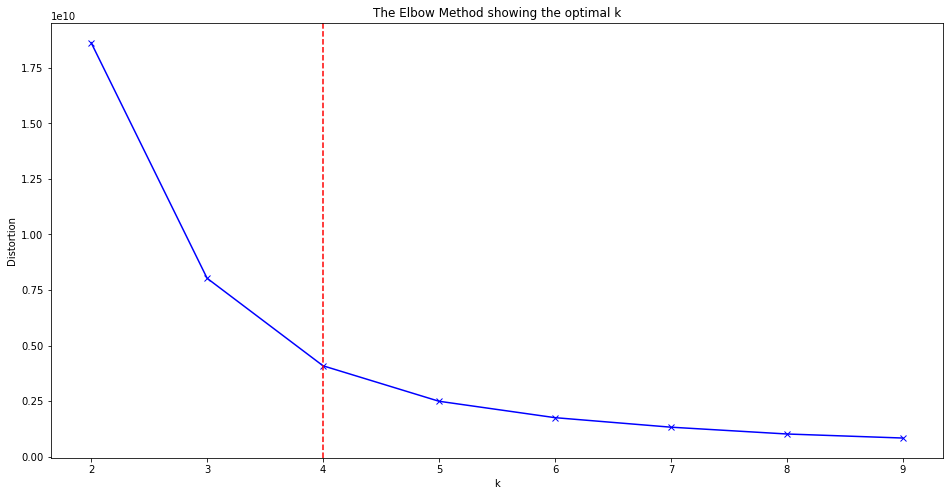

In [56]:
distortions = []
K = range(2,10)
for k in K:
    clust_mod = KMeans(n_clusters=k)
    labels = clust_mod.fit_predict(cases_US_curr)
    distortions.append(clust_mod.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.axvline(x=4, color='red', linestyle='--')
plt.show()

In [59]:
clust_mod = KMeans(n_clusters=4)
clust_mod.fit(cases_US_curr)
cases_US_curr['cluster'] = clust_mod.labels_

cases_US_clust = cases_US_curr.groupby('cluster').mean()
cases_US_clust

,Cases_Delta,Avg_Temp,Protest_Count,Perc.Over.65,Perc.White,Perc.Female,Perc.Black,Perc.Native,Perc.Asian,Perc.Pac.Island,Perc.Mixed,Perc.His.Lat,Perc.Foreign.Born,Avg.Person.Per.Household,PopDensity,major/varies,minor,minor/varies,moderate,moderate/varies,none,D,R,Cases_2W
cluster,,,,,,,,,,,,,,,,,,,,,,,,
0,4.33368,72.18405,0.80206,17.45814,86.77299,49.90880,8.30014,2.00337,1.08598,0.08213,1.74986,8.61467,4.05708,2.51682,60.02445,0.01753,0.50412,0.20069,0.14261,0.11615,0.01890,0.37560,0.62440,328.19691
1,311.22222,75.20000,15.88889,13.71111,72.47778,51.31111,18.87778,0.84444,5.71111,0.10000,1.98889,24.45556,21.25556,2.78000,1285.27432,0.00000,0.22222,0.22222,0.22222,0.33333,0.00000,0.55556,0.44444,34191.77778
2,1209.00000,71.00000,45.00000,12.30000,68.70000,51.10000,16.90000,1.15000,10.75000,0.25000,2.35000,36.50000,28.10000,2.83000,1529.36069,0.50000,0.00000,0.00000,0.00000,0.50000,0.00000,1.00000,0.00000,97193.00000
3,79.33333,73.54231,8.87179,13.30256,74.39872,51.06538,15.81154,0.88077,6.36667,0.17564,2.36154,20.74487,17.31538,2.68654,808.02379,0.07692,0.25641,0.14103,0.34615,0.17949,0.00000,0.53846,0.46154,10706.94872


## Cluster 0

In [64]:
cases_US_curr[cases_US_curr['cluster'] == 0]

,Cases_Delta,Avg_Temp,Protest_Count,Perc.Over.65,Perc.White,Perc.Female,Perc.Black,Perc.Native,Perc.Asian,Perc.Pac.Island,Perc.Mixed,Perc.His.Lat,Perc.Foreign.Born,Avg.Person.Per.Household,PopDensity,major/varies,minor,minor/varies,moderate,moderate/varies,none,D,R,Cases_2W,cluster
County,,,,,,,,,,,,,,,,,,,,,,,,,
Abbeville,0.00000,76.10000,0.00000,18.70000,69.90000,51.40000,28.20000,0.30000,0.40000,0.00000,1.30000,1.20000,1.00000,2.49000,19.30746,0,1,0,0,0,0,0,1,113.00000,0
Accomack,11.00000,74.20000,2.00000,20.80000,69.00000,51.50000,28.00000,0.60000,0.60000,0.20000,1.50000,9.00000,7.00000,2.25000,27.75811,0,0,0,0,1,0,1,0,1042.00000,0
Ada,71.00000,64.20000,1.00000,12.10000,92.50000,50.00000,1.30000,0.80000,2.60000,0.20000,2.60000,7.50000,5.90000,2.60000,176.65322,0,1,0,0,0,0,0,1,2169.00000,0
Adair,1.00000,74.00000,0.00000,22.10000,98.50000,50.50000,0.20000,0.10000,0.40000,0.00000,0.70000,1.50000,1.10000,2.26000,4.85077,0,1,0,0,0,0,0,1,15.00000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yuma,0.00000,74.40000,0.00000,17.20000,97.30000,49.90000,0.30000,0.90000,0.40000,0.20000,0.80000,21.60000,10.90000,2.61000,1.63608,0,0,0,1,0,0,1,0,52.00000,0
Zapata,1.00000,84.40000,0.00000,11.20000,98.60000,49.60000,0.50000,0.40000,0.20000,0.00000,0.20000,93.50000,24.50000,3.17000,5.48326,0,0,1,0,0,0,0,1,47.00000,0
Zavala,0.00000,83.20000,0.00000,12.50000,96.90000,50.20000,1.20000,0.90000,0.10000,0.10000,0.70000,92.90000,11.20000,3.15000,3.52352,0,0,1,0,0,0,0,1,21.00000,0
Ziebach,0.00000,69.30000,0.00000,7.00000,24.30000,50.40000,0.40000,71.60000,0.30000,0.00000,3.40000,3.70000,0.90000,3.51000,0.54255,0,1,0,0,0,0,0,1,2.00000,0


***Cluster 0 consists of most counties in the country. These are low population, Republican led, mostly white, vitually no protests, and have generally small concern for COVID-19 exmplaining the majority of minor restrictions.***

## Cluster 1

In [61]:
cases_US_curr[cases_US_curr['cluster'] == 1]

,Cases_Delta,Avg_Temp,Protest_Count,Perc.Over.65,Perc.White,Perc.Female,Perc.Black,Perc.Native,Perc.Asian,Perc.Pac.Island,Perc.Mixed,Perc.His.Lat,Perc.Foreign.Born,Avg.Person.Per.Household,PopDensity,major/varies,minor,minor/varies,moderate,moderate/varies,none,D,R,Cases_2W,cluster
County,,,,,,,,,,,,,,,,,,,,,,,,,
Harris,450.00000,81.40000,5.00000,9.00000,70.70000,50.10000,19.50000,1.10000,6.80000,0.10000,1.70000,41.60000,25.00000,2.89000,1068.29762,0,0,1,0,0,0,0,1,31422.00000,1
Maricopa,1497.00000,86.00000,11.00000,13.40000,84.70000,50.50000,5.70000,2.70000,4.00000,0.30000,2.70000,30.00000,14.90000,2.72000,188.23918,0,1,0,0,0,0,0,1,48592.00000,1
Miami-Dade,532.00000,83.20000,7.00000,14.90000,77.80000,51.40000,19.00000,0.30000,1.70000,0.00000,1.20000,65.60000,51.30000,3.02000,552.77682,0,1,0,0,0,0,0,1,36820.00000,1
Middlesex,77.00000,69.20000,26.00000,13.80000,81.70000,51.20000,5.40000,0.30000,10.50000,0.10000,2.10000,7.30000,19.30000,2.52000,760.90094,0,0,0,1,0,0,0,1,23962.00000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Philadelphia,64.00000,74.20000,1.00000,12.40000,45.50000,52.70000,44.20000,0.80000,6.90000,0.10000,2.40000,13.30000,12.20000,2.56000,4560.85073,0,0,0,1,0,0,1,0,26133.00000,1
Suffolk,32.00000,69.40000,37.00000,14.90000,85.60000,50.80000,8.20000,0.60000,3.80000,0.10000,1.70000,17.70000,14.50000,2.95000,625.09557,0,0,0,0,1,0,1,0,41385.00000,1
Wayne,92.00000,70.60000,13.00000,13.50000,54.70000,51.90000,39.60000,0.50000,2.90000,0.00000,2.30000,5.60000,7.80000,2.66000,1103.49075,0,0,1,0,0,0,1,0,22767.00000,1
Westchester,27.00000,71.00000,18.00000,15.40000,74.90000,51.70000,15.90000,0.80000,6.10000,0.10000,2.20000,23.30000,25.00000,2.71000,867.72563,0,0,0,0,1,0,1,0,34838.00000,1


***The counties in cluster 1 are mostly consist of medium to large cities that have a pretty even split of political leadership, a high black population, and started to have growth in cases. These have yet to spike like cluster 2, but are showing signs of more outbreaks. A significant statistic of this cluster is that there were no counties that had major restrictions. This would be an interesting group of counties to conduct further analysis of after June 2020 as it has notable variance around a number of features.***

## Cluster 2

In [62]:
cases_US_curr[cases_US_curr['cluster'] == 2]

,Cases_Delta,Avg_Temp,Protest_Count,Perc.Over.65,Perc.White,Perc.Female,Perc.Black,Perc.Native,Perc.Asian,Perc.Pac.Island,Perc.Mixed,Perc.His.Lat,Perc.Foreign.Born,Avg.Person.Per.Household,PopDensity,major/varies,minor,minor/varies,moderate,moderate/varies,none,D,R,Cases_2W,cluster
County,,,,,,,,,,,,,,,,,,,,,,,,,
Cook,320.00000,71.70000,32.00000,12.70000,65.90000,51.50000,24.60000,0.80000,6.90000,0.10000,1.80000,24.70000,21.10000,2.65000,2103.51372,0,0,0,0,1,0,1,0,90536.00000,2
Los Angeles,2098.00000,70.30000,58.00000,11.90000,71.50000,50.70000,9.20000,1.50000,14.60000,0.40000,2.90000,48.30000,35.10000,3.01000,955.20766,1,0,0,0,0,0,1,0,103850.00000,2


***This cluster took the two worst counties in the country at the time, LA and Cook, which have very similar numbers. It is interesting that it separated these two from the rest in cluster 1. An interesting future analysis could be to compare the differences between cluster 1 and 2.***

## Cluster 3

In [63]:
cases_US_curr[cases_US_curr['cluster'] == 3]

,Cases_Delta,Avg_Temp,Protest_Count,Perc.Over.65,Perc.White,Perc.Female,Perc.Black,Perc.Native,Perc.Asian,Perc.Pac.Island,Perc.Mixed,Perc.His.Lat,Perc.Foreign.Born,Avg.Person.Per.Household,PopDensity,major/varies,minor,minor/varies,moderate,moderate/varies,none,D,R,Cases_2W,cluster
County,,,,,,,,,,,,,,,,,,,,,,,,,
Alameda,52.00000,69.50000,14.00000,12.20000,52.00000,51.00000,12.40000,1.20000,28.20000,1.00000,5.20000,22.70000,30.80000,2.76000,873.18782,1,0,0,0,0,0,1,0,5964.00000,3
Baltimore,81.00000,72.80000,7.00000,15.50000,64.10000,52.60000,27.50000,0.40000,5.70000,0.10000,2.30000,4.80000,11.10000,2.52000,533.92798,0,0,0,0,1,0,0,1,7985.00000,3
Bergen,27.00000,71.90000,19.00000,15.80000,75.00000,51.60000,6.70000,0.40000,15.90000,0.10000,1.90000,17.90000,29.60000,2.69000,1544.67594,0,0,0,1,0,0,1,0,19423.00000,3
Bexar,439.00000,81.50000,2.00000,11.00000,85.40000,50.80000,8.20000,1.20000,2.80000,0.20000,2.10000,59.10000,13.10000,2.84000,623.94215,0,0,1,0,0,0,0,1,10797.00000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Will,31.00000,72.50000,4.00000,10.70000,81.00000,50.30000,11.60000,0.40000,5.10000,0.10000,1.70000,16.30000,11.70000,3.02000,318.66888,0,0,0,0,1,0,1,0,6686.00000,3
Worcester,18.00000,67.80000,15.00000,13.80000,88.00000,50.70000,5.10000,0.40000,4.50000,0.10000,1.90000,10.10000,11.30000,2.59000,212.27898,0,0,0,1,0,0,0,1,12350.00000,3
Yakima,54.00000,58.80000,3.00000,12.50000,88.20000,49.80000,1.50000,5.90000,1.40000,0.20000,2.80000,47.00000,18.10000,3.02000,22.55029,0,0,0,0,1,0,1,0,7071.00000,3
Yuma,0.00000,86.40000,1.00000,16.80000,91.30000,48.90000,2.70000,2.20000,1.50000,0.20000,2.00000,61.10000,25.30000,2.73000,14.96984,0,1,0,0,0,0,0,1,6225.00000,3


***Cluster 3 is very similar to cluster 1 as it contains more medium sized counties/cities although the main difference being these counties have yet to have major outbreaks. Comparing cluster 1 and 3 could help identify what is correlated with more cases 2 weeks later.***